In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mnist = keras.datasets.mnist
cifar10 = keras.datasets.cifar10

database = 1
if database:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
else:
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.reshape(x_test.shape + (1,))

# Preprocess the data
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

# Add data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No data augmentation for validation data
val_datagen = ImageDataGenerator()

# Split the training data into training and validation sets
split_index = int(0.9 * len(x_train)) 
x_train_split, x_val = x_train[:split_index], x_train[split_index:]
y_train_split, y_val = y_train[:split_index], y_train[split_index:]


In [6]:
batch_size = 32
epochs = 30

# Create generators for augmented training data and non-augmented validation data
train_generator = train_datagen.flow(x_train_split, y_train_split, batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size)


In [8]:
model = Sequential([
    Conv2D(32, (5,5), padding='same', activation='relu', input_shape=x_train.shape[1:4]),
    BatchNormalization(),
    Conv2D(32, (5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(strides=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(strides=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'), #, kernel_regularizer=l2(0.01)
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [10]:
train_acc_values = []
val_acc_values = []
test_acc_values = []
train_loss_values = []
val_loss_values = []
test_loss_values = []

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.995:
            print("\nReached 99.5% accuracy so cancelling training!")
            self.model.stop_training = True
        
        # Evaluate the model on the validation set after each epoch
        val_loss, val_acc = self.model.evaluate(val_generator, verbose=0)
        
        # Append accuracy and loss values to lists
        train_acc_values.append(logs.get('acc'))
        val_acc_values.append(val_acc)
        train_loss_values.append(logs.get('loss'))
        val_loss_values.append(val_loss)
        
        # Evaluate the model on the test set after each epoch
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)
        
        # Append test accuracy and loss values to the lists
        test_acc_values.append(test_acc)
        test_loss_values.append(test_loss)

callbacks = myCallback()

In [11]:
if (database) :
    history = model.fit(train_generator,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[callbacks])
else : 
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.1,
                        callbacks=[callbacks])



Epoch 1/30
1407/1407 [==============================] - 155s 109ms/step - loss: 1.9921 - acc: 0.2635 - val_loss: 1.7443 - val_acc: 0.3750
Epoch 2/30
1407/1407 [==============================] - 151s 108ms/step - loss: 1.6867 - acc: 0.3750 - val_loss: 1.3647 - val_acc: 0.4984
Epoch 3/30
1407/1407 [==============================] - 150s 106ms/step - loss: 1.5183 - acc: 0.4422 - val_loss: 1.2705 - val_acc: 0.5510
Epoch 4/30
1407/1407 [==============================] - 150s 106ms/step - loss: 1.4070 - acc: 0.4958 - val_loss: 1.0783 - val_acc: 0.6146
Epoch 5/30
1407/1407 [==============================] - 151s 107ms/step - loss: 1.2892 - acc: 0.5457 - val_loss: 1.0116 - val_acc: 0.6610
Epoch 6/30
1407/1407 [==============================] - 152s 108ms/step - loss: 1.1900 - acc: 0.5884 - val_loss: 0.9092 - val_acc: 0.6806
Epoch 7/30
1407/1407 [==============================] - 151s 107ms/step - loss: 1.1120 - acc: 0.6184 - val_loss: 0.8749 - val_acc: 0.7012
Epoch 8/30
1407/1407 [============

In [12]:
test_loss, test_acc = model.evaluate(x_test, y_test)


313/313 [==============================] - 6s 21ms/step - loss: 0.5204 - acc: 0.8308


[0.26348888874053955, 0.37495556473731995, 0.4421555697917938, 0.4957999885082245, 0.545711100101471, 0.5884222388267517, 0.6183555722236633, 0.6445333361625671, 0.6670222282409668, 0.6867777705192566, 0.6955778002738953, 0.7081778049468994, 0.7224888801574707, 0.7316444516181946, 0.7402666807174683, 0.7481333613395691, 0.7543555498123169, 0.7601110935211182, 0.7676222324371338, 0.7695555686950684, 0.7730888724327087, 0.7783555388450623, 0.7818889021873474, 0.7823333144187927, 0.786911129951477, 0.7908444404602051, 0.7939110994338989, 0.7917110919952393, 0.7973555326461792, 0.798466682434082]


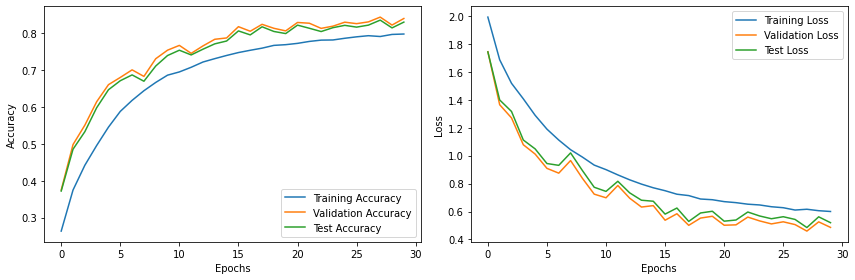

In [13]:
# 1. Plot accuracy for training, validation, and testing on one graph
# Plotting
plt.figure(figsize=(12, 4))
print(train_acc_values)
# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


/home/happy/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  del sys.path[0]


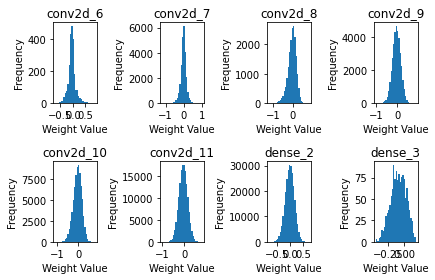

In [14]:
# 3. Histograms of each layer's weights
fig, ax = plt.subplots(2,3,constrained_layout = True)
i=0
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        plt.subplot(2, 4, i+1)
        weights, biases = layer.get_weights()
        plt.hist(weights.flatten(), bins=30)
        plt.title(f'{layer.name}')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        i = i+1
fig.tight_layout()
plt.show()

313/313 [==============================] - 6s 20ms/step


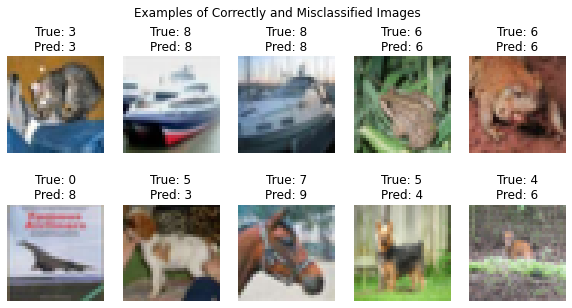

In [15]:
# 4. Show examples of correctly classified and miss-classified images
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

correctly_classified_indices = np.where(y_pred == y_true)[0]
misclassified_indices = np.where(y_pred != y_true)[0]

# Display some correctly classified images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[correctly_classified_indices[i]], cmap='gray')
    plt.title(f'True: {y_true[correctly_classified_indices[i]]}\nPred: {y_pred[correctly_classified_indices[i]]}')
    plt.axis('off')

# Display some misclassified images
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(x_test[misclassified_indices[i]], cmap='gray')
    plt.title(f'True: {y_true[misclassified_indices[i]]}\nPred: {y_pred[misclassified_indices[i]]}')
    plt.axis('off')

plt.suptitle('Examples of Correctly and Misclassified Images')
plt.show()


1/1 [==============================] - 0s 180ms/step


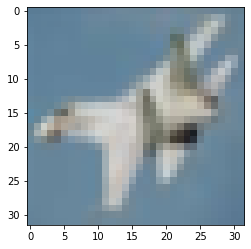

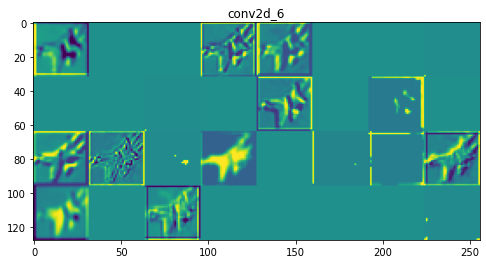

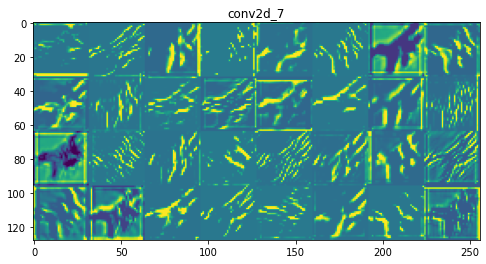

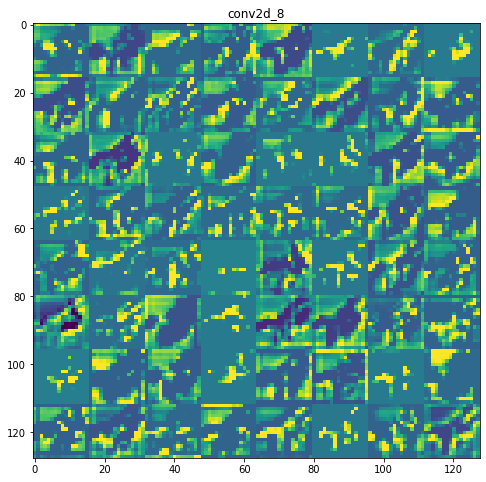

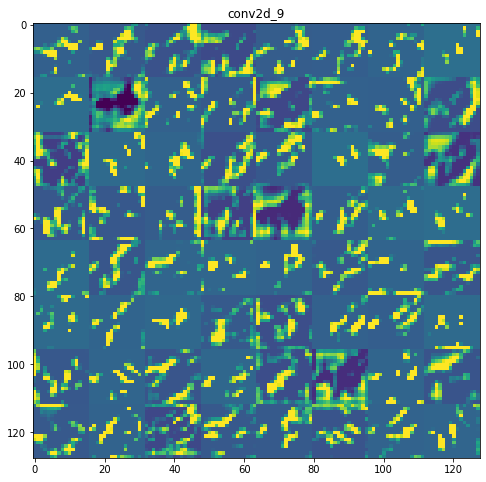

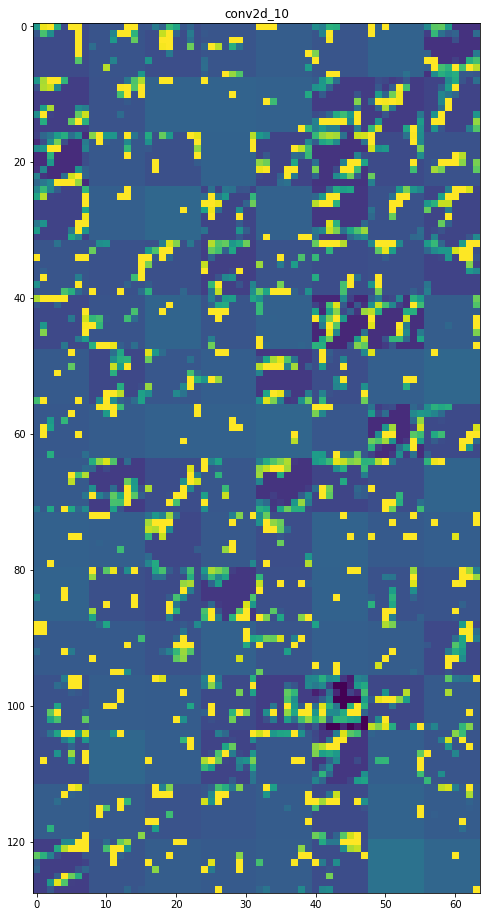

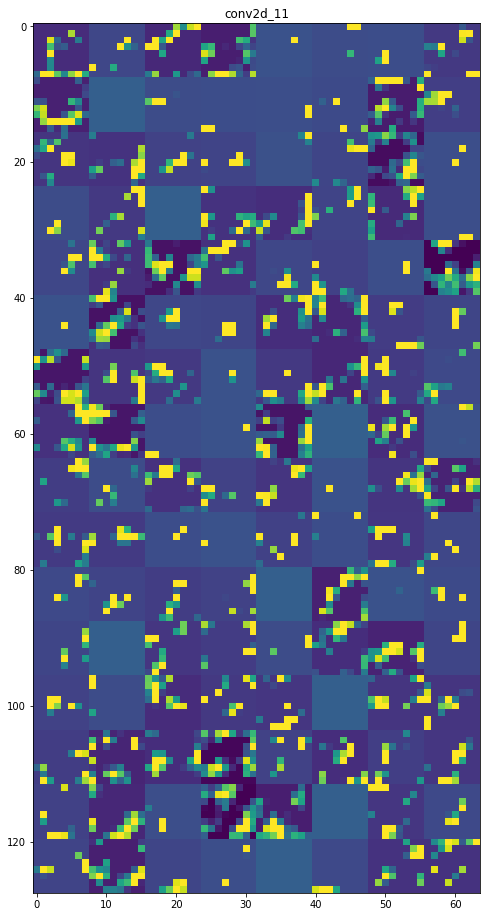

In [17]:
# Observe feature maps from different convolutional layers
layer_outputs = [layer.output for layer in model.layers] 
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

example_image = x_test[10].reshape(1, 32, 32, 3)  # Take the first test image for visualization
activations = activation_model.predict(example_image)
plt.imshow(x_test[10])
plt.show()
# Plot the feature maps
layer_names = [layer.name for layer in model.layers]

for layer_name, layer_activation in zip(layer_names, activations):
    if 'conv' in layer_name:
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // 8  # Display up to 8 feature maps per row
        display_grid = np.zeros((size * n_cols, 8 * size))

        for col in range(n_cols):
            for row in range(8):
                channel_image = layer_activation[0, :, :, col * 8 + row]
                channel_image -= channel_image.mean()
                channel_image_std = channel_image.std()
                channel_image_std = channel_image_std if channel_image_std > 0 else 1e-10  # Avoid division by zero
                channel_image /= channel_image_std
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image


        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()